<h1 style="color:rgb(0,120,170)"> Decision Trees</h1>

In [12]:
# nothing to do here
import numpy as np
import pandas as pd
import sys
import time
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mnist_loader import MNIST
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# Set random seed to ensure reproducible runs
RSEED = 50

In [13]:

X = np.array([[2, 2], 
              [2, 1],
              [2, 3], 
              [1, 2], 
              [1, 1],
              [3, 3],
              [3, 2]])

y = np.array([0, 1, 1, 1, 0, 1, 0])

Text(0.5, 1.0, 'Demonstration Data')

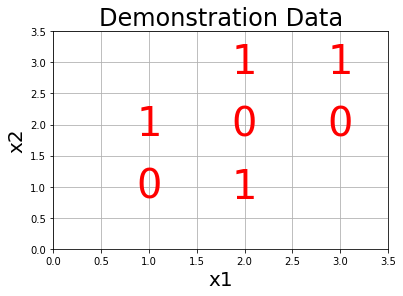

In [14]:
%matplotlib inline

for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, str(label), fontsize = 40, color = 'r',
             ha='center', va='center')
    
# plot formatting
plt.grid(None)
plt.xlim((0, 3.5))
plt.ylim((0, 3.5))
plt.xlabel('x1', size = 20); plt.ylabel('x2', size = 20); plt.title('Demonstration Data', size = 24)

In [15]:
"""
Function that calculates the Gini Impurity of the whole dataset and of the two datasets after a split is performed.
Returns also the impurity gain from this specific split.
@param X, np ndarray, data matrix
@param y, np ndarray, data vector
@param split, float, value for splitting
@param entry, int, indicating at which entry/axis/dimension the split should be performed (e.g. if entry=0 then you
would perform the split for the first feature, for entry=1 it's the second feature)
"""
def calc_gini(X,y,split,entry):   
    def count_unique_labels(labels): 
        unique_labels = list(set(labels)) #get labels of our y-vector
        count_first_label = 0
        count_second_label = 0
        len_labels = len(labels)
        for label in labels:
            if unique_labels[0] == label:
                count_first_label +=1
            else:
                count_second_label += 1
        return count_first_label,count_second_label,len_labels
    
    def calc_gini_impurity(count_first_label,count_second_label,len_labels):
        return 1-(count_first_label/len_labels)**2-(count_second_label/len_labels)**2
    
    count_first_label,count_second_label,len_labels = count_unique_labels(y)
    gini_impurity = calc_gini_impurity(count_first_label,count_second_label,len_labels)
    
    #performing split analysis
    def split_labels(X,y,entry):
        elem_idx_top_split = list()
        elem_idx_bottom_split = list()
        for element in X:
            if element[entry]>=split:
                elem_idx_top_split.append(y[np.where((X == element).all(axis=1))[0][0]])
            else:
                elem_idx_bottom_split.append(y[np.where((X == element).all(axis=1))[0][0]])
        return elem_idx_top_split,elem_idx_bottom_split
                
    elem_idx_top_split,elem_idx_bottom_split = split_labels(X,y,entry)
    
    top_split_first_label,top_split_second_label,len_labels_top = count_unique_labels(elem_idx_top_split)
    bottom_split_first_label,bottom_split_second_label,len_labels_bottom = count_unique_labels(elem_idx_bottom_split)

    gini_top = calc_gini_impurity(top_split_first_label,top_split_second_label,len_labels_top)
    gini_bottom = calc_gini_impurity(bottom_split_first_label,bottom_split_second_label,len_labels_bottom)
    
    impurity_gain = gini_impurity - (len_labels_top/len_labels)*gini_top - (len_labels_bottom/len_labels)*gini_bottom
    return gini_impurity, gini_top, gini_bottom, impurity_gain

In [16]:
gini_impurity, gini_top, gini_bottom, impurity_gain = calc_gini(X,y,2.5,1)
print("Gini impurity: {}\nGini impurity top leaf: {}\nGini impurity bottom leaf: {}\nGini impurity gain: {}".format(gini_impurity, gini_top, gini_bottom, impurity_gain))

Gini impurity: 0.489795918367347
Gini impurity top leaf: 0.0
Gini impurity bottom leaf: 0.48
Gini impurity gain: 0.14693877551020412


In [17]:
"""
Trains a decision tree and returns certain attributes of the received model.
@param seed, int, seed for preserving reproducibility of random events
@param X, np ndarray, data matrix
@param y, np ndarray, data vector
"""
# Make a decision tree and train
def dec_tree(seed,X,y):
    classifier = DecisionTreeClassifier(random_state=RSEED)
    classifier = classifier.fit(X,y)
    max_depth = classifier.tree_.max_depth
    nr_nodes = classifier.tree_.node_count
    acc = classifier.score(X,y)
    
    return nr_nodes, max_depth, acc

In [18]:
# print number of tree nodes and the maximum depth of tree
nr_nodes, max_depth, acc = dec_tree(RSEED,X,y)
print(f'Decision tree has {nr_nodes} nodes with maximum depth {max_depth}.')
print(f'Model accuracy: {acc}')

Decision tree has 11 nodes with maximum depth 4.
Model accuracy: 1.0


<h2 style="color:rgb(0,120,170)">Decision tree on a real data set (25 points)</h2>

In [19]:

data = MNIST('./dataset/')
img_train, labels_train = data.load_training()
x_train = np.array(img_train)
y_train = np.array(labels_train)

img_test, labels_test = data.load_testing()
x_test = np.array(img_test)
y_test = np.array(labels_test)

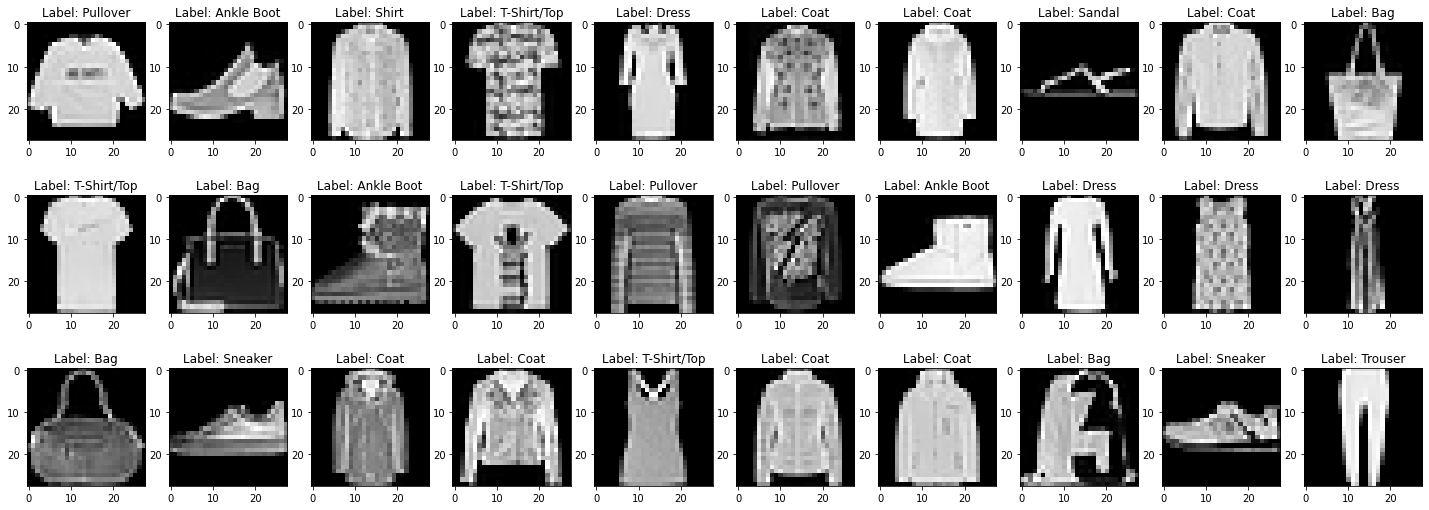

In [20]:

arr = ['T-Shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
plt.figure(figsize=(25, 9))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    two_d = (np.reshape(x_train[i], (28, 28))).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest',cmap='gray')
    plt.title('Label: {0}'.format(arr[y_train[i]]))
plt.show()

In [21]:

print('\nPreparing classifier...')
model = DecisionTreeClassifier(criterion="gini", max_depth=50, splitter="best", random_state=RSEED)
model.fit(x_train,y_train)


Preparing classifier...


DecisionTreeClassifier(max_depth=50, random_state=50)

In [22]:

"""
Evaluates the model and returns accuracy as well as a confusion matrix. Also the time for prediction can is calculated.
@param model, sklearn model, trained model
@param x_test, np ndarray, data matrix
@param y_test, np ndarray, data vector
"""
def get_evaluation(model, x_test, y_test):
    start = time.time()
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)

    print('\nPredicted values: ', y_pred)
    print('\nAccuracy of classifier on test image data: ', accuracy)
    print('\nConfusion matrix: \n', conf_mat)
    print('\nTime: ', time.time()-start)

    plt.matshow(conf_mat)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None


Predicted values:  [0 1 6 ... 8 8 2]

Accuracy of classifier on test image data:  0.7983

Confusion matrix: 
 [[735   5  14  43   8   3 179   1  12   0]
 [  5 965   3  16   4   0   5   0   2   0]
 [ 24   4 682  18 140   3 119   0   9   1]
 [ 43  33  17 818  48   1  36   0   4   0]
 [ 10   2 147  43 687   1 103   0   6   1]
 [  2   1   1   2   2 876   1  61  21  33]
 [172   8  99  41 107   3 553   0  16   1]
 [  1   0   0   0   0  52   2 865   5  75]
 [ 18   2  17   6  13  11  19   6 905   3]
 [  1   0   1   2   1  27   3  66   2 897]]

Time:  0.02299642562866211


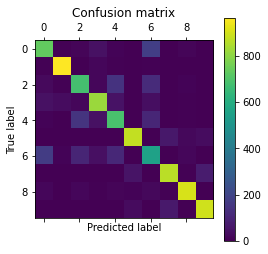

In [23]:

_ = get_evaluation(model, x_test, y_test)

In [24]:

param_dict_grid = {'criterion':('gini','entropy'),
                   'max_depth':[10,50,100],
                   'splitter':('random','best')}
"""
Trains a decision tree using cross-validation and returns certain attributes of the received model including the best
parameter combination.
@param x_train, np ndarray, data matrix
@param y_train, np ndarray, data vector
@param param_grid, dict, grid holding the paramaters for search
@param seed, int , seed for preserving reducibility of random events
@param n_iter, int, number of iterations (RandomizedSearchCV)
@param cv, in, number of folds (RandomizedSearchCV)
"""
def train_dec_tree(x_train,y_train,param_dict_grid,seed,n_iter,cv):
    np.random.seed(seed)
    model = DecisionTreeClassifier(random_state=seed)
    clf = RandomizedSearchCV(estimator=model,param_distributions=param_dict_grid,cv=cv,n_iter=n_iter)
    model = clf.fit(x_train,y_train)
    #modesl
    
    return model.best_params_,model


Predicted values:  [0 1 6 ... 8 2 1]

Accuracy of classifier on test image data:  0.8105

Confusion matrix: 
 [[743   6  18  39  10   4 168   0  12   0]
 [  7 966   4  15   2   1   3   0   1   1]
 [ 23   3 692  10 146   0 115   0  11   0]
 [ 40  28  16 830  38   1  40   0   5   2]
 [  7   2 143  56 704   1  83   0   4   0]
 [  3   0   1   2   0 889   1  66   9  29]
 [160   8  99  48  87   0 581   0  17   0]
 [  0   0   0   0   0  56   0 871   5  68]
 [  8   1  11   8   4  13  16   6 926   7]
 [  0   1   0   0   0  30   0  61   5 903]]

Time:  0.024073123931884766
The best parameters are: {'splitter': 'best', 'max_depth': 50, 'criterion': 'entropy'}


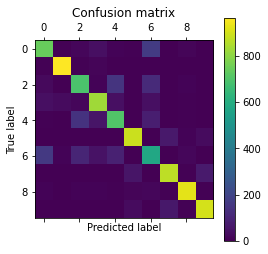

In [25]:
params_dec_tree, model_dec_tree = train_dec_tree(x_train,y_train,param_dict_grid,RSEED,5,3)
_ = get_evaluation(model_dec_tree, x_test, y_test)
print("The best parameters are: {}".format(params_dec_tree))

<h2 style="color:rgb(0,120,170)"> Comparison with KNN and SVMs (30 points)</h2>

In [26]:
"""
Trains a KNN classifier on the given dataset.
@param x_train, np ndarray, data matrix
@param y_train, np ndarray, data vector
@param n_neighbors, int, number of neighbors
@param weights, str, mode for weights
@param p, float, power parameter for the Minkowski metric (see documentation: neighbors.KNeighborsClassifier)
"""
def trainKNN(x_train,y_train,n_neighbors,weights,p):
    model = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights,p=p)
    model.fit(x_train,y_train)
    return model


Predicted values:  [0 1 2 ... 8 8 2]

Accuracy of classifier on test image data:  0.8671

Confusion matrix: 
 [[875   1  13  12   3   0  88   2   6   0]
 [  5 970   8  14   1   0   2   0   0   0]
 [ 12   1 804  11  84   0  87   0   1   0]
 [ 35   9   8 888  35   0  23   0   2   0]
 [  3   0 107  27 784   0  78   0   1   0]
 [  0   0   0   1   0 881   0  70   1  47]
 [198   2 111  19  68   0 596   0   6   0]
 [  0   0   0   0   0   6   0 949   0  45]
 [  4   1  11   0   4   2   8  10 958   2]
 [  0   0   0   0   0   3   0  31   0 966]]

Time:  386.3773488998413


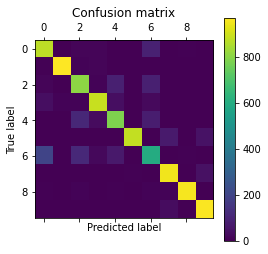

In [27]:
knn_model = trainKNN(x_train,y_train,5,'distance',1)
_ = get_evaluation(knn_model, x_test, y_test)

In [28]:
"""
Trains an SVM classifier on the given dataset.
@param x_train, np ndarray, data matrix
@param y_train, np ndarray, data vector
@param kernel, str, type of kernel being used
@param gamma, float, kernel coefficient
"""
def trainSVM(x_train,y_train,C,kernel,gamma,seed):
    model = svm.SVC(C=C,kernel=kernel,gamma=gamma,random_state=seed)
    model.fit(x_train,y_train)
    return model


Predicted values:  [0 1 2 ... 8 8 1]

Accuracy of classifier on test image data:  0.8772

Confusion matrix: 
 [[827   0  19  18   2   1 121   0  10   2]
 [  1 988   0   8   1   0   2   0   0   0]
 [ 23   2 816  13  76   1  65   0   4   0]
 [ 44  19  21 870  23   0  23   0   0   0]
 [  7   3 100  35 794   0  58   0   3   0]
 [  2   0   0   1   0 946   0  31   3  17]
 [140   6  87  34  57   0 667   0   9   0]
 [  0   0   0   0   0  16   0 942   0  42]
 [ 13   0   3   2   2   2  13   1 963   1]
 [  0   0   0   0   0  13   0  27   1 959]]

Time:  70.81012535095215


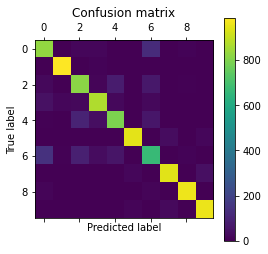

In [29]:
svm_model = trainSVM(x_train,y_train,10,'poly','auto',RSEED)
_ = get_evaluation(svm_model, x_test, y_test)

In [30]:

# Accuracy:
classifier1 = 0.9876
# Parameters:
parameter1 = 'split'

dec_tree_fixed_params_acc = 0.7983

# your solution:
dec_tree_best_params_acc = 0.8105
KNN_acc = 0.8671
SVM_acc = 0.8772

# Best parameters dec_tree:
par_splitter_ = 'best'
par_maxdepth_ = 50
par_criterion_ = 'entropy'

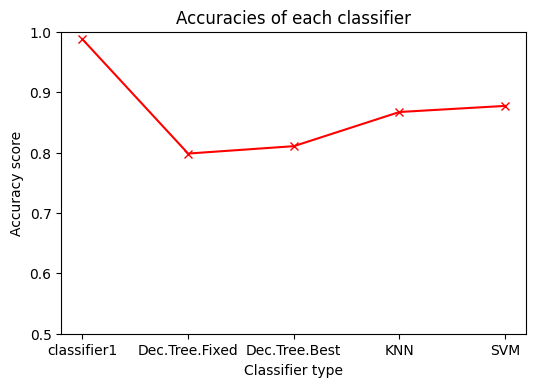

In [31]:

classifiers_y = ['classifier1','Dec.Tree.Fixed','Dec.Tree.Best','KNN','SVM']
classifiers_x = [classifier1,dec_tree_fixed_params_acc,dec_tree_best_params_acc,KNN_acc,SVM_acc]

fig = plt.figure(dpi=100)
plt.plot(classifiers_y,classifiers_x,color="red",marker='x')
plt.ylim(ymin=0.5,ymax=1)
plt.xlabel('Classifier type')
plt.ylabel('Accuracy score')
plt.title('Accuracies of each classifier')
plt.show()





$$ 
\begin{align}
\mathrm{Var}\left( \overline {X}\right)&= \frac{1}{B^2} \sum_{i=1}^{B} \sum_{j=1}^{B} Cov(X_i,X_j) \\
\text{Split }i = j \dashrightarrow \mathrm{Var}\left( \overline {X}\right)&=\frac{1}{B^2} \sum_{i=1}^{B} \sum_{j=1}^{B} \sigma^2 \\
\text{Split }i \neq j \dashrightarrow \mathrm{Var}\left( \overline {X}\right)&=\frac{1}{B^2} \sum_{i=1}^{B} \sum_{j=1}^{B} \sigma^2*\rho \\
\text{Replace sums with number of occurences} \dashrightarrow  \mathrm{Var}\left( \overline {X}\right)&= \frac{1}{B^2}(B*\sigma^2 + B(B-1)\sigma^2\rho) = \\
 \frac{\sigma^2}{B} + \rho*\sigma^2-\frac{\rho*\sigma^2}{B} = \rho \sigma^2 +\frac{1-\rho}{B} \sigma^2. \quad (1)
\end{align}
$$

In [33]:
# executability check
calc_gini(np.eye(2),np.ones(2),0.5,1)
dec_tree(RSEED,np.ones((2,2)),np.ones(2))
train_dec_tree(np.ones((10,2)),np.ones(10),{"max_depth":[1,2,4,5,6]},RSEED,10,10)
trainKNN(np.ones((10,2)),np.ones(10),1,'distance',1)
trainSVM(np.ones((4,2)),np.array([0,1,0,1]),1,'poly','auto',RSEED)
print("Executable")

Executable


c:\Users\dreka\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
